In [1]:
import numpy as np
import datetime as dt

from qubic.lib.Qgps import GPS, GPS_old

%matplotlib widget

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
data_path = "calsource_orientation_20240322.dat"
observation_date = np.array([dt.datetime(2024, 3, 22, 10, 8, 00)]) # np.array([dt.datetime(2024, 3, 22, 9, 47, 49), dt.datetime(2024, 3, 22, 16, 13, 49, 500000)])#

In [3]:
distance_between_antennas = 1
distance_calsource = 0.5
gps_old = GPS_old(data_path, distance_between_antennas, distance_calsource, observation_date)

[[ 0.2774556 ]
 [ 0.55819241]
 [-0.01504918]]
[[ 0.9796]
 [-0.1538]
 [-0.0073]]
[[ 0.6285278 ]
 [ 0.20219621]
 [-0.01117459]]


In [4]:
position_ini_antenna1 = gps_old.position_antenna1[:, 0]
position_ini_antenna2 = gps_old.position_antenna2[:, 0]
position_ini_calsource = gps_old.position_calsource[:, 0]
position_ini_calsource -= np.array([0, 0, 0.5])
gps = GPS(data_path, position_ini_antenna1, position_ini_antenna2, position_ini_calsource, observation_date, position_qubic = np.array([0, 0, 0]), ini_wrt_antenna2=False)

In [5]:
position_ini_antenna1

array([ 0.2774556 ,  0.55819241, -0.01504918])

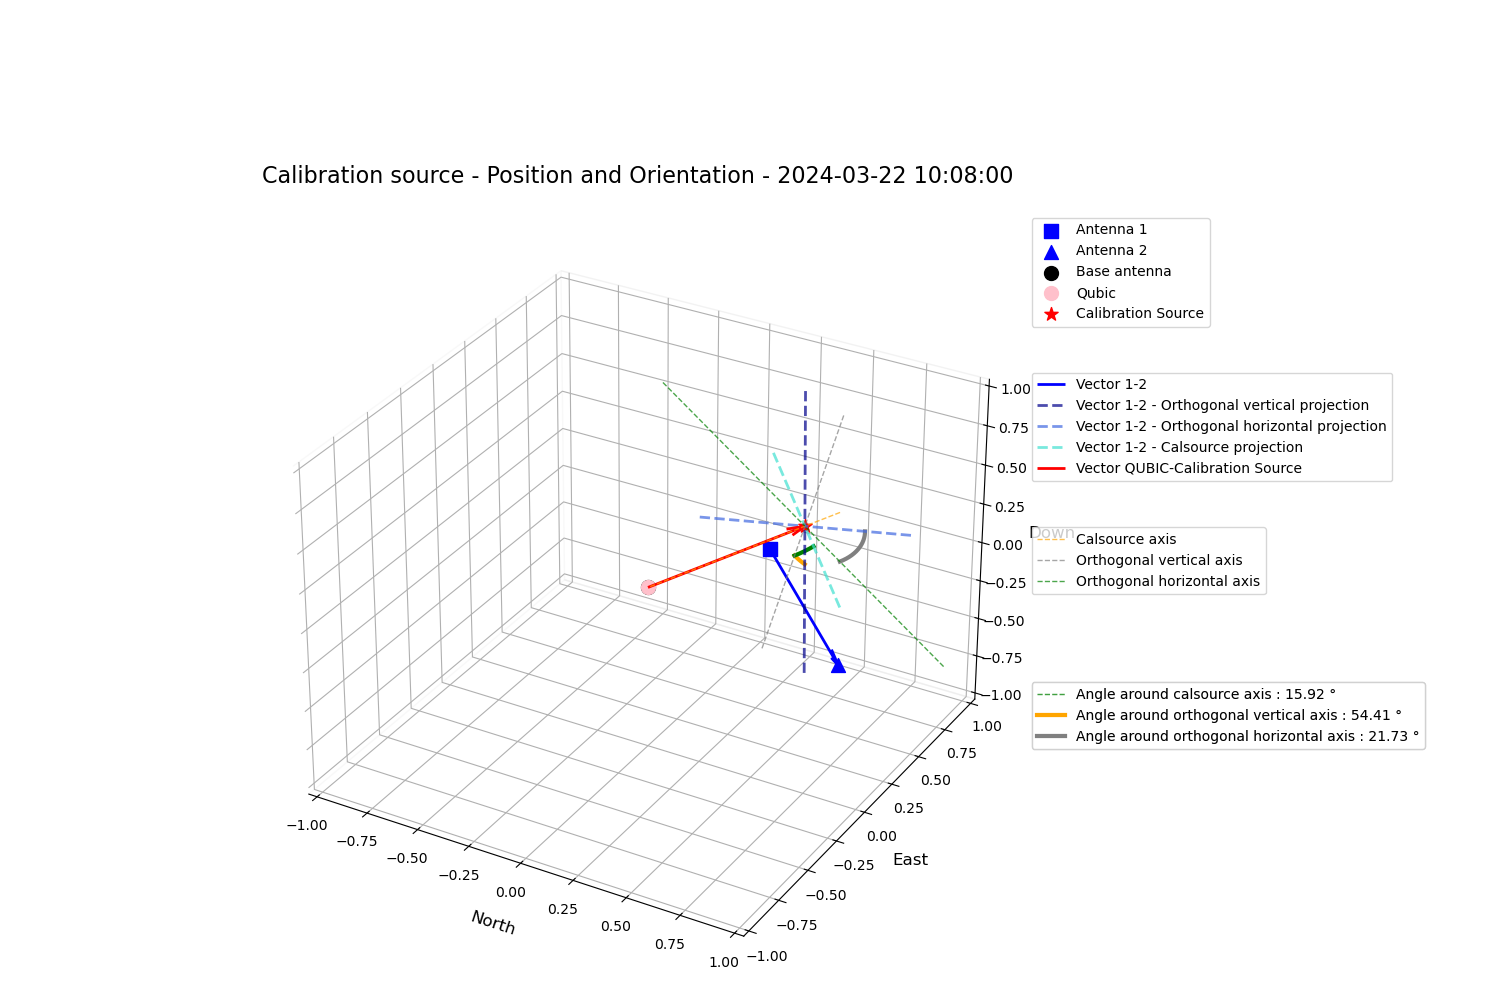

In [6]:
gps.plot_system()